<a href="https://colab.research.google.com/github/MaxCojocari/Py_labs/blob/main/forecasting_covid_de.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* https://towardsdatascience.com/a-lightgbm-autoregressor-using-sktime-6402726e0e7b

* https://github.com/alan-turing-institute/sktime/blob/main/examples/01_forecasting.ipynb

* https://www.sktime.org/en/stable/

* https://towardsdatascience.com/why-start-using-sktime-for-forecasting-8d6881c0a518


In [139]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [140]:
!pip install sktime[all_extras]

In [141]:
import numpy as np
import pandas as pd
from sktime.utils.plotting import plot_series
from sktime.datasets import load_airline
y=load_airline()
y

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

In [142]:
# # #Upload the data frame
# y = pd.read_csv('/content/drive/MyDrive/PBL_sem2/cases_covid_de.csv')
# y = y['cases'].loc[y['date'] >= '2022-01-01']
# # # plotting for visualization
# y = pd.Series([float(x) for x in y['cases']], index=y['date'])
# #plot_series(y)


y = pd.read_csv('/content/drive/MyDrive/PBL_sem2/cases_covid_de.csv',
                index_col=0, squeeze=True, dtype={1: np.float})

# make sure time index is properly formatted
#y.index = pd.to_datetime(y.index)
y.index = pd.PeriodIndex(y.index, freq='D')
y.name = "Number of cases"


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


In [143]:
y

date
2021-03-01      4683.0
2021-03-02     10945.0
2021-03-03     11324.0
2021-03-04     10127.0
2021-03-05      9655.0
                ...   
2022-02-08    244623.0
2022-02-09    241216.0
2022-02-10    218249.0
2022-02-11    178730.0
2022-02-12     79542.0
Freq: D, Name: Number of cases, Length: 349, dtype: float64

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3028517cd0>)

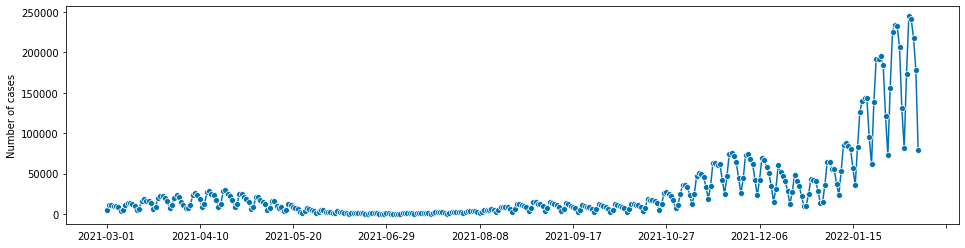

In [147]:
plot_series(y, markers=['o'])

In [194]:
from sktime.forecasting.base import ForecastingHorizon
fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("2021-01", periods=14, freq="D")), is_relative=False
)
fh

ForecastingHorizon(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
             '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
             '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
             '2021-01-13', '2021-01-14'],
            dtype='period[D]', is_relative=False)

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f302758a0d0>)

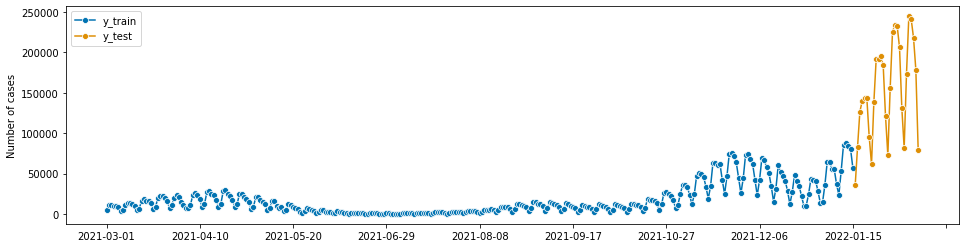

In [258]:
from sktime.forecasting.model_selection import temporal_train_test_split
y_train, y_test = temporal_train_test_split(y, test_size=28)
plot_series(y_train, y_test, labels=["y_train", "y_test"])

In [259]:
print(y_train.shape[0], y_test.shape[0])

321 28


In [260]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [261]:
#NaiveForecaster
from sktime.forecasting.naive import NaiveForecaster

# we can simply take the indices from `y_test` where they already are stored
fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = NaiveForecaster(strategy="last", sp=7)

forecaster.fit(y_train)

# y_pred will contain the predictions
y_pred = forecaster.predict(fh)

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f302790b550>)

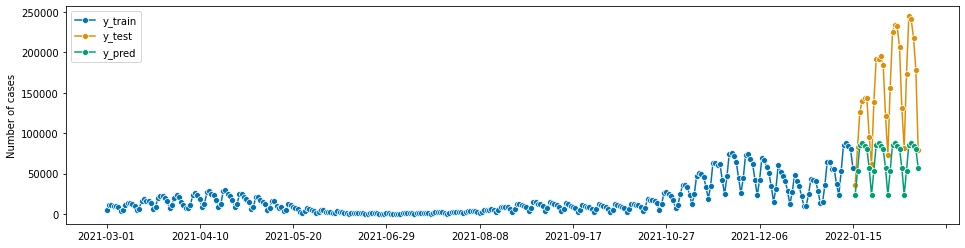

In [262]:
# plotting for illustration
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [263]:
mean_absolute_percentage_error(y_test, y_pred)

0.7577010080441214

In [284]:
#Setting the data for test and train
y_train, y_test = temporal_train_test_split(y, test_size=7)

#Setting the forecasting horizon
fh = ForecastingHorizon(y_test.index, is_relative=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


0.13602938635974943

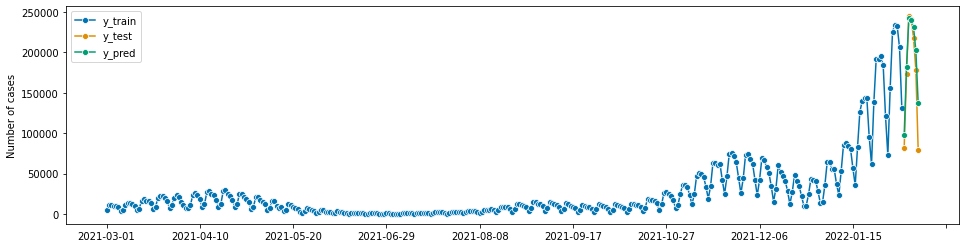

In [285]:
#exponential smoothing algorithm

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(trend=None, seasonal="Additive", sp=7)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

0.13474843725515268

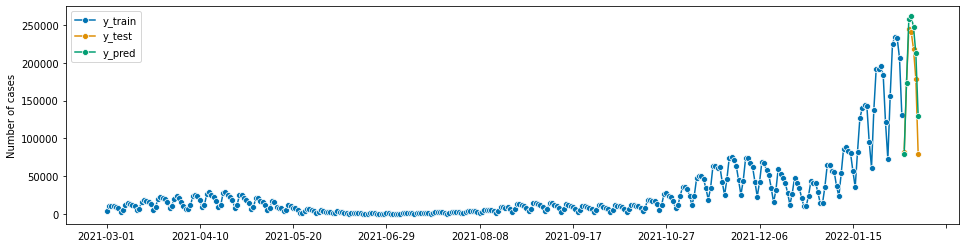

In [286]:
#AutoETS
from sktime.forecasting.ets import AutoETS
forecaster = AutoETS(auto=True, sp=7, n_jobs=-1)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


0.1875919419600412

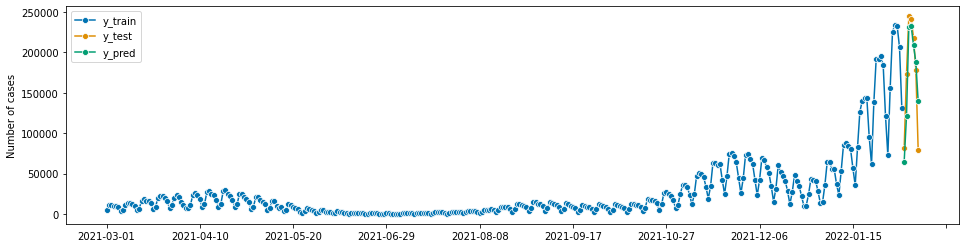

In [287]:
from sktime.forecasting.theta import ThetaForecaster
forecaster = ThetaForecaster(sp=7)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

0.13423360552150446

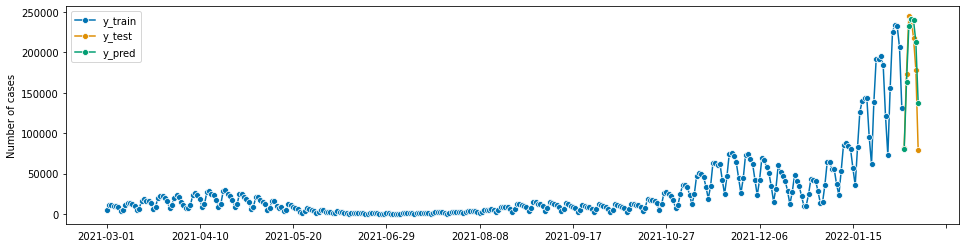

In [288]:
#ARIMA
from sktime.forecasting.arima import ARIMA
forecaster = ARIMA(
    order=(1, 1, 0), seasonal_order=(0, 1, 0, 7), suppress_warnings=True
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

0.14222794049438445

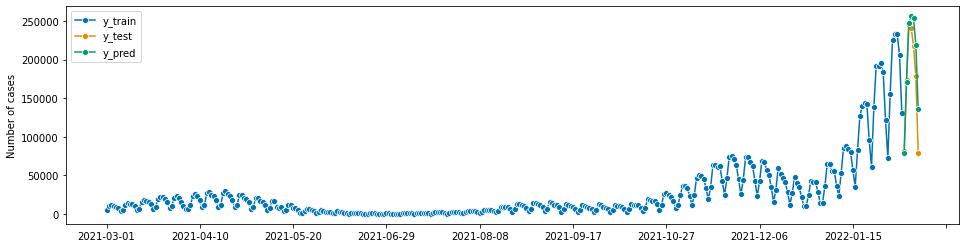

In [289]:
#AutoARIMA
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=7, suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [290]:
# to obtain the fitted parameters, run
forecaster.get_fitted_params()

{'aic': 6442.925019482669,
 'aicc': 6443.368096405746,
 'ar.L1': -0.7364038248705468,
 'ar.S.L14': 0.20265132212048048,
 'ar.S.L7': 0.3506573839337961,
 'bic': 6473.4141474264825,
 'hqic': 6455.08145045733,
 'ma.L1': 0.9313799309026533,
 'ma.L2': -0.38348021217247646,
 'ma.L3': -0.3999091083591386,
 'ma.L4': 0.16083804637458213,
 'order': (1, 1, 4),
 'seasonal_order': (2, 1, 0, 7),
 'sigma2': 15914383.674383726}

In [291]:
#BATS and TBATS
from sktime.forecasting.bats import BATS
from sktime.forecasting.tbats import TBATS
forecaster_BATS = BATS(sp=7, use_trend=True, use_box_cox=False)
forecaster_TBATS = TBATS(sp=7, use_trend=True, use_box_cox=False)

forecaster_BATS.fit(y_train)
forecaster_TBATS.fit(y_train)

TBATS(sp=7, use_box_cox=False, use_trend=True)

0.152654223757372

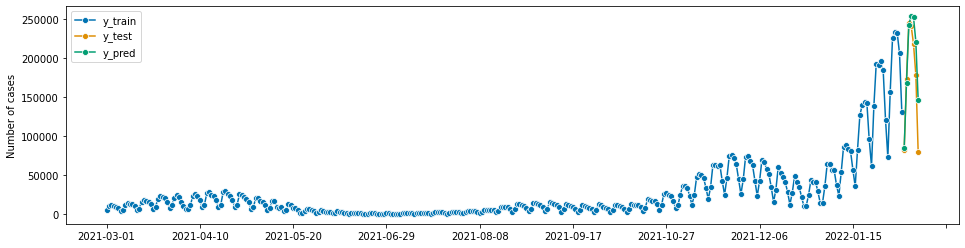

In [292]:
y_pred = forecaster_BATS.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

0.19272753885259236

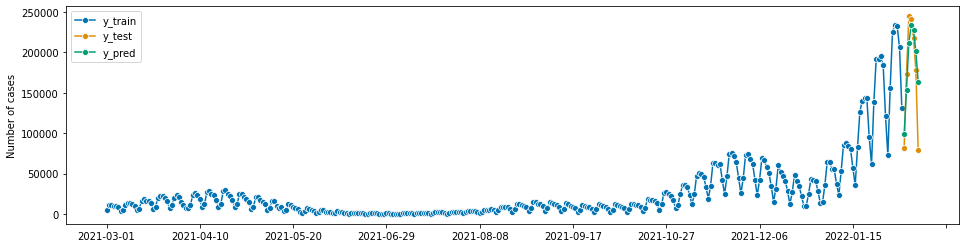

In [293]:
y_pred = forecaster_TBATS.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [294]:
#Facebook Prophet
from sktime.forecasting.fbprophet import Prophet

In [295]:
#The current interface does not support period indices, only pd.DatetimeIndex.
#Consider improving this by contributing the sktime.

#Convert index to pd.DatetimeIndex
z = y.copy()
z = z.to_timestamp(freq="D")
z_train, z_test = temporal_train_test_split(z, test_size=7)

/usr/local/lib/python3.7/dist-packages/sktime/forecasting/base/_fh.py:322: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  cutoff = _coerce_to_period(cutoff, freq=cutoff.freqstr)


0.34935776035187055

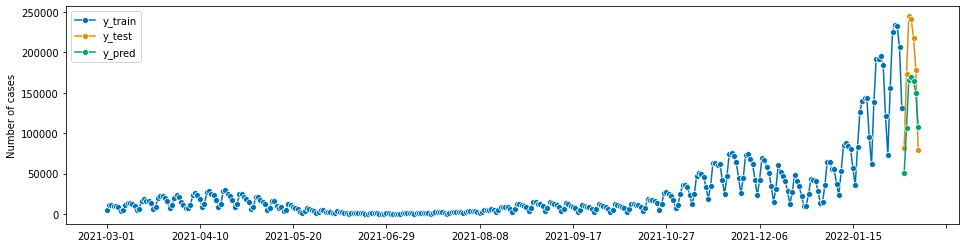

In [296]:
forecaster = Prophet(
    seasonality_mode="multiplicative",
    n_changepoints=int(len(y_train) / 7),
    add_country_holidays={"country_name": "Germany"},
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
)

forecaster.fit(z_train)
y_pred = forecaster.predict(fh.to_relative(cutoff=y_train.index[-1]))
y_pred.index = y_test.index

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

0.13474843725515268

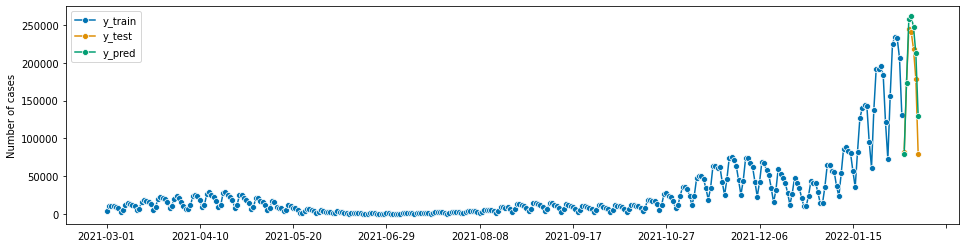

In [318]:
#ETS
from sktime.forecasting.ets import AutoETS
forecaster = AutoETS(auto=True, n_jobs=-1, sp=7)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [332]:
# advanced evaluation worfklow: rolling re-sampling and aggregate errors, rolling back-testing
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter

In [333]:
forecaster = AutoARIMA(sp=7, suppress_warnings=True)

cv = ExpandingWindowSplitter(
    step_length=7, fh=[1, 2, 3, 4, 5, 6, 7], initial_window=int(len(y))-7*12
)

df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True)

df.iloc[:, :5]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.050776,52.597821,0.013372,265,2021-11-20
1,0.167995,45.755278,0.008541,272,2021-11-27
2,0.089148,67.649364,0.012459,279,2021-12-04
3,0.050155,68.995193,0.014378,286,2021-12-11
4,0.259912,51.580818,0.012081,293,2021-12-18
5,0.957478,75.057288,0.010629,300,2021-12-25
6,0.378790,78.902560,0.010297,307,2022-01-01
7,0.118452,84.634842,0.010614,314,2022-01-08
8,0.217723,43.305457,0.009383,321,2022-01-15
9,0.079073,51.805855,0.015296,328,2022-01-22


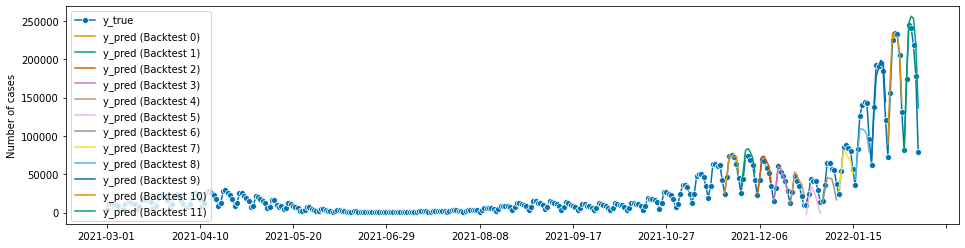

In [334]:
# visualization of a forecaster evaluation
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    df["y_pred"].iloc[5],
    df["y_pred"].iloc[6],
    df["y_pred"].iloc[7],
    df["y_pred"].iloc[8],
    df["y_pred"].iloc[9],
    df["y_pred"].iloc[10],
    df["y_pred"].iloc[11],
    markers=["o", "", "", "", "", "", "", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(12)],
)
ax.legend();

In [321]:
forecaster = ARIMA(
    order=(1, 1, 0), seasonal_order=(2, 1, 0, 7), suppress_warnings=True
)

cv = ExpandingWindowSplitter(
    step_length=7, fh=[1, 2, 3, 4, 5, 6, 7], initial_window=int(len(y))-7*12
)

df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True)

df.iloc[:, :5]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.079559,0.942032,0.034760,265,2021-11-20
1,0.080687,0.494317,0.012529,272,2021-11-27
2,0.082181,0.629931,0.024627,279,2021-12-04
3,0.062772,0.573813,0.021839,286,2021-12-11
4,0.264738,0.604653,0.027062,293,2021-12-18
5,1.173177,0.791471,0.012070,300,2021-12-25
6,0.400630,0.364758,0.011843,307,2022-01-01
7,0.099548,0.399117,0.012600,314,2022-01-08
8,0.246326,0.404753,0.011921,321,2022-01-15
9,0.093412,0.367518,0.012776,328,2022-01-22


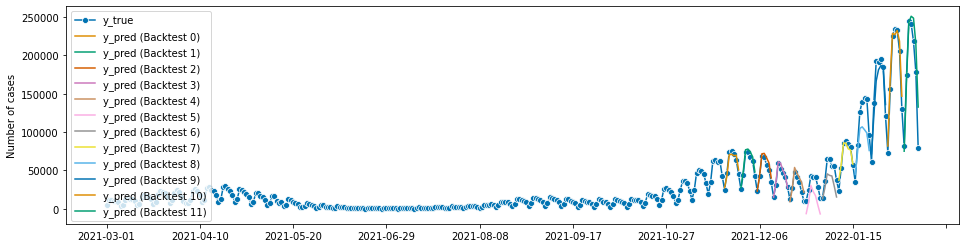

In [322]:
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    df["y_pred"].iloc[5],
    df["y_pred"].iloc[6],
    df["y_pred"].iloc[7],
    df["y_pred"].iloc[8],
    df["y_pred"].iloc[9],
    df["y_pred"].iloc[10],
    df["y_pred"].iloc[11],
    markers=["o", "", "", "", "", "", "", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(12)],
)
ax.legend();

In [319]:
forecaster = AutoETS(auto=True, n_jobs=-1, sp=7)
cv = ExpandingWindowSplitter(
    step_length=7, fh=[1, 2, 3, 4, 5, 6, 7], initial_window=int(len(y))-7*12
)

df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True)

df.iloc[:, :5]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.109161,0.987324,0.004278,265,2021-11-20
1,0.086473,1.160586,0.004258,272,2021-11-27
2,0.128056,0.984901,0.006246,279,2021-12-04
3,0.124128,0.902762,0.004024,286,2021-12-11
4,0.292875,0.950153,0.004026,293,2021-12-18
5,0.574702,1.001145,0.004242,300,2021-12-25
6,0.489968,1.000773,0.004068,307,2022-01-01
7,0.194779,0.946704,0.005629,314,2022-01-08
8,0.215911,1.219099,0.004091,321,2022-01-15
9,0.098210,0.996981,0.004260,328,2022-01-22


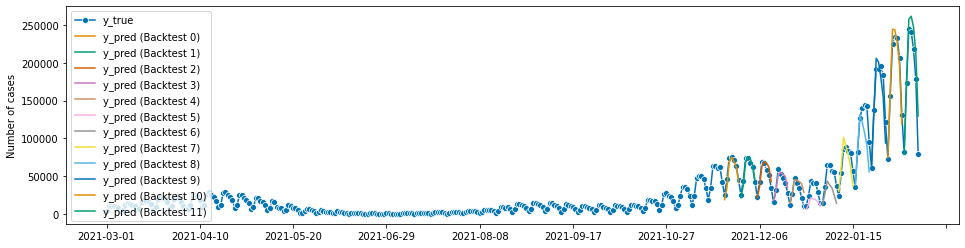

In [320]:
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    df["y_pred"].iloc[5],
    df["y_pred"].iloc[6],
    df["y_pred"].iloc[7],
    df["y_pred"].iloc[8],
    df["y_pred"].iloc[9],
    df["y_pred"].iloc[10],
    df["y_pred"].iloc[11],
    markers=["o", "", "", "", "", "", "", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(12)],
)
ax.legend();

In [324]:
forecaster = BATS(sp=7, use_trend=True, use_box_cox=False)
cv = ExpandingWindowSplitter(
    step_length=7, fh=[1, 2, 3, 4, 5, 6, 7], initial_window=int(len(y))-7*12
)

df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True)

df.iloc[:, :5]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.253831,47.935000,0.007176,265,2021-11-20
1,0.172682,46.171971,0.006470,272,2021-11-27
2,0.219634,42.058094,0.006427,279,2021-12-04
3,0.077202,44.885858,0.006810,286,2021-12-11
4,0.208491,47.767424,0.007524,293,2021-12-18
5,1.129179,62.002359,0.006530,300,2021-12-25
6,0.481878,61.240754,0.006220,307,2022-01-01
7,0.106790,54.310219,0.006633,314,2022-01-08
8,0.277017,41.507462,0.006544,321,2022-01-15
9,0.118887,63.083225,0.006545,328,2022-01-22


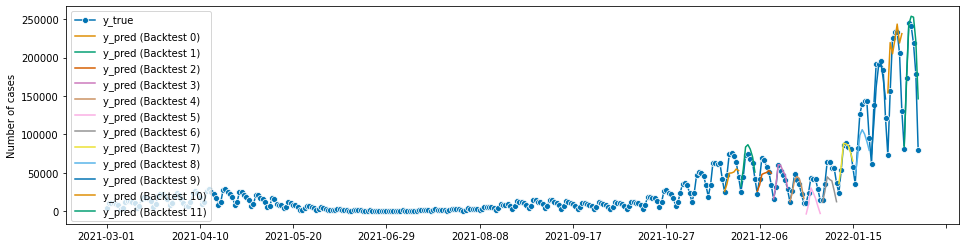

In [325]:
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    df["y_pred"].iloc[5],
    df["y_pred"].iloc[6],
    df["y_pred"].iloc[7],
    df["y_pred"].iloc[8],
    df["y_pred"].iloc[9],
    df["y_pred"].iloc[10],
    df["y_pred"].iloc[11],
    markers=["o", "", "", "", "", "", "", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(12)],
)
ax.legend();